## Next frame prediction using Conv-LSTM2D Network on MNIST moving digits

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 20 07:09:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Imports and getting the data set ready

819200096/819200096 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step
Training Dataset Shapes: (4500, 19, 64, 64, 1), (4500, 19, 64, 64, 1)
Validation Dataset Shapes: (500, 19, 64, 64, 1), (500, 19, 64, 64, 1)
Displaying frames for example 1678.


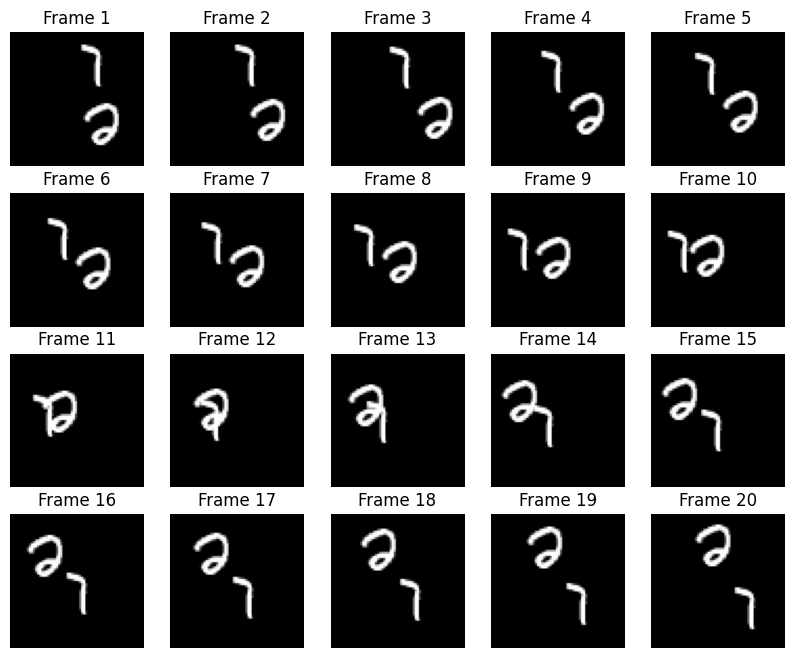

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)


# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:5000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()



#### Constructing a base model: ConvLSTM2D Neural Network to learn patterns  in moving images

In [ ]:

# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, 64, 64, 1)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, None, 64, 64, 64)    │         416,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, None, 64, 64, 64)    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, None, 64, 64, 64)    │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, 64, 64, 64)    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, None, 64, 64, 64)    │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, None, 64, 64, 1)     │           1,729 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 746,689 (2.85 MB)

 Trainable params: 746,433 (2.85 MB)

 Non-trainable params: 256 (1.00 KB)

### Model Training

In [ ]:

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 97s 95ms/step - loss: 0.0772 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - loss: 0.0254 - val_loss: 0.0251 - learning_rate: 0.0010
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - loss: 0.0245 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - loss: 0.0242 - val_loss: 0.0241 - learning_rate: 0.0010
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - loss: 0.0240 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - loss: 0.0238 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - loss: 0.0238 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - loss: 0.0237 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 9/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - loss: 0.0236 - val_loss: 0.0239 - learning_rate:

### Trained model example: Original vs. Predicted timesteps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


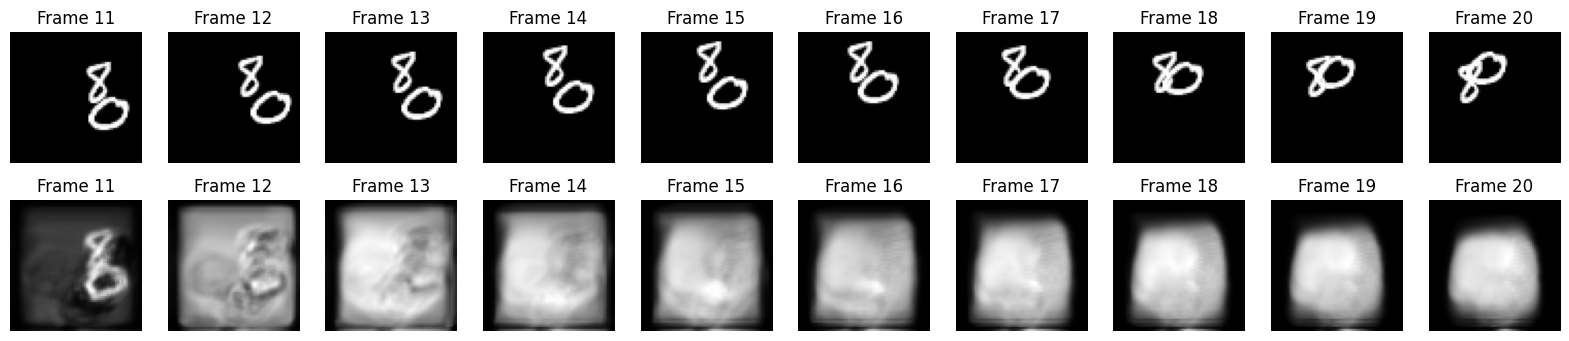

In [ ]:

# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

In [ ]:
val_dataset.shape

(500, 20, 64, 64, 1)

In [ ]:
train_dataset.shape

(4500, 20, 64, 64, 1)

In [ ]:
# Select a few random examples from the dataset.
num_examples = 50
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=num_examples)]
# examples = val_dataset
training_frames = 10
original_frames_img = np.zeros(shape=(num_examples, training_frames, *frames[0].shape))
new_predictions_img = np.zeros(shape=(num_examples, training_frames, *frames[0].shape))


for ex,example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:training_frames, ...] # This is not needed, overwritten later
    original_frames = example[training_frames:, ...]
    original_frames_img[ex] = example[training_frames:, ...]
    new_predictions = np.zeros(shape=(training_frames, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(training_frames):
        # Extract the model's prediction and post-process it.
        frames = example[:training_frames + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame
    new_predictions_img[ex] = new_predictions

In [ ]:
orig_images = original_frames_img[:,:,:,:,0]
pred_images = new_predictions_img[:,:,:,:,0]

In [ ]:
ssd_per_image = np.zeros(orig_images.shape[0:2])

for i in range(orig_images.shape[0]):
  for t in range(orig_images.shape[1]):
    curr_orig_img_t = orig_images[i][t] # Shape: (64,64)
    curr_pred_img_t = pred_images[i][t] # Shape: (64,64)
    curr_ssd_t = np.sum(np.square(np.subtract(curr_orig_img_t,curr_pred_img_t))) #scalar
    curr_ssd_t_normalize = np.sqrt(np.multiply(np.sum(curr_orig_img_t**2),np.sum(curr_pred_img_t**2)))
    ssd_per_image[i][t] = curr_ssd_t/ curr_ssd_t_normalize

print(ssd_per_image.shape)


(50, 10)


### Predicted movie

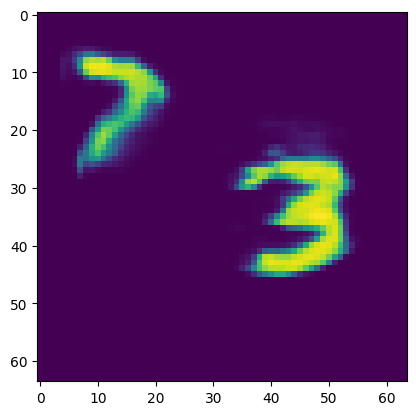

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.random import randn
from time import sleep

for t in range(orig_images.shape[1]):
  sleep(0.5)
  plt.imshow(pred_images[45][t])
  plt.show()
  clear_output(wait=True)

### Original Movie

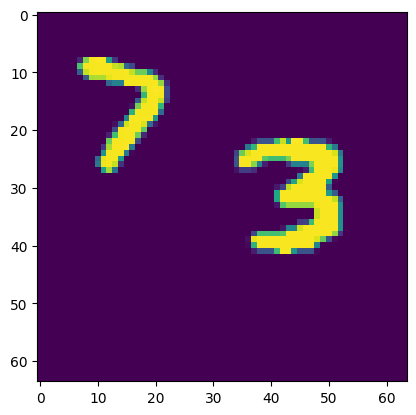

In [ ]:

for t in range(orig_images.shape[1]):
  clear_output(wait=True)
  sleep(0.3)
  plt.imshow(orig_images[45][t])
  plt.show()


In [ ]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp

In [ ]:

print("MSE: ", mse(pred_images[0][0],orig_images[0][0]))
print("RMSE: ", rmse(pred_images[0][0],orig_images[0][0]))

print("UQI: ", uqi(pred_images[0][0],orig_images[0][0]))

print("ERGAS: ", ergas(pred_images[0][0],orig_images[0][0]))
print("SCC: ", scc(pred_images[0][0],orig_images[0][0]))
print("RASE: ", rase(pred_images[0][0],orig_images[0][0]))
print("SAM: ", sam(pred_images[0][0],orig_images[0][0]))
print("VIF: ", vifp(pred_images[0][0],orig_images[0][0]))

MSE:  0.040449160241852494
RMSE:  0.20111976591536818
UQI:  0.14642109330631176
ERGAS:  38.570789124634175
SCC:  -0.0019674682686851453
RASE:  8647.43803818803
SAM:  0.9226853620247539
VIF:  0.7169227066416572


In [ ]:
mse_t_series = np.zeros(shape=(orig_images.shape[0],orig_images.shape[1]))

In [ ]:
# This is the mean squared error calculation
for im in range(orig_images.shape[0]):
  for t in range(orig_images.shape[1]):
    mse_t_series[im][t] = rmse(orig_images[im][t], pred_images[im][t])


In [ ]:
normalized_rmse_t_series = np.zeros(shape=(orig_images.shape[0],orig_images.shape[1]))
# This is the normalization of RMSE calculation
st_dev = np.std(mse_t_series)
for im in range(mse_t_series.shape[0]):
    mean = np.mean(mse_t_series[im])

    normalized_rmse_t_series[im] = (mse_t_series[im] - mean)/ st_dev




In [ ]:
import pandas as pd
import numpy as np

df_describe = pd.DataFrame(mse_t_series)
df_describe.describe()

,0,1,2,3,4,5,6,7,8,9
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.186472,0.178578,0.172659,0.170921,0.177036,0.180606,0.186059,0.189197,0.193612,0.196216
std,0.014851,0.017658,0.019270,0.020809,0.020207,0.025083,0.024788,0.022822,0.021503,0.019337
min,0.156733,0.129467,0.122266,0.130032,0.128569,0.128993,0.125714,0.141389,0.144121,0.154656
25%,0.173926,0.166627,0.156981,0.158252,0.164089,0.165400,0.174444,0.177734,0.183021,0.180574
50%,0.186951,0.178113,0.170872,0.167833,0.178517,0.182915,0.185894,0.188100,0.190065,0.196388
75%,0.198195,0.188991,0.190550,0.187211,0.192420,0.196404,0.203161,0.204649,0.208252,0.207083
max,0.222907,0.209827,0.209385,0.211025,0.211040,0.225450,0.242580,0.242305,0.243172,0.239885


### Error propagation over time

Text(0, 0.5, 'Mean Sq. Error')

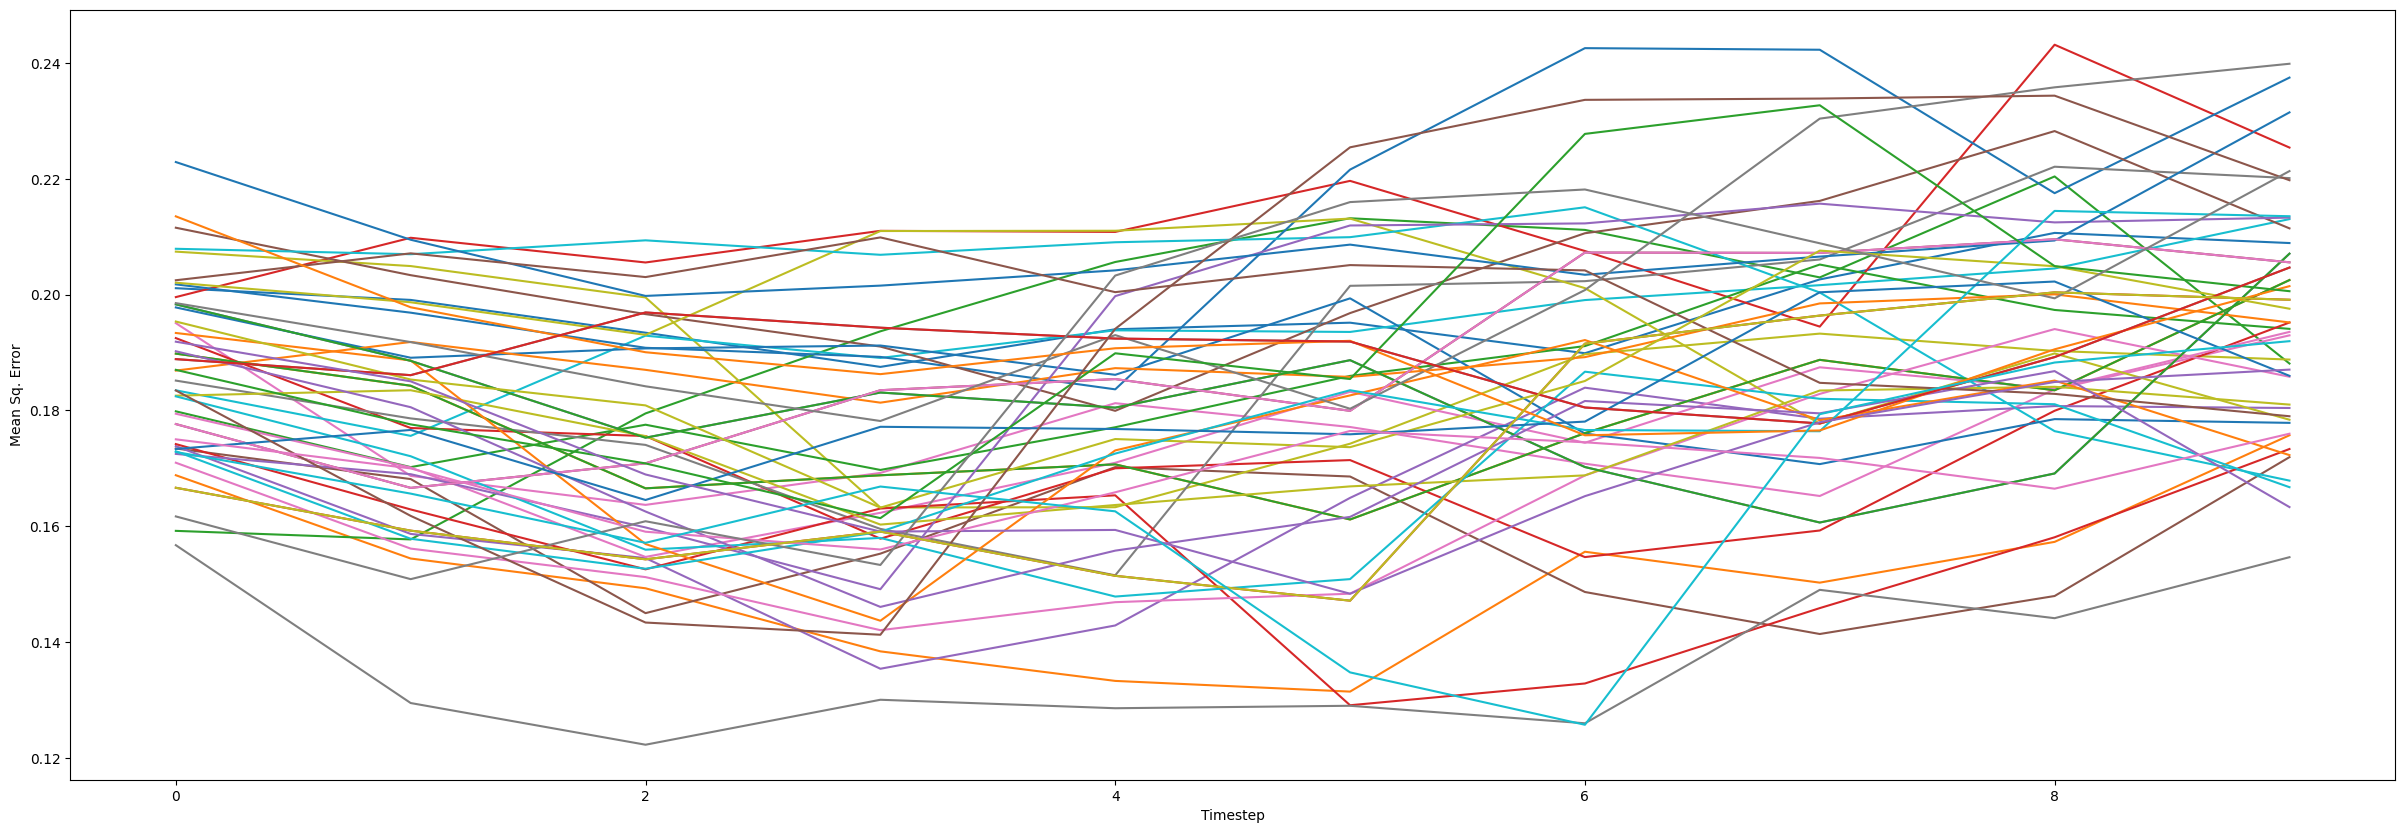

In [ ]:
plt.figure(figsize=(30,10))
for i in range(orig_images.shape[0]):
  plt.plot(range(10), mse_t_series[i], '-', label=i)

plt.xlabel("Timestep")
plt.ylabel("Mean Sq. Error")
# plt.legend(loc="best")